In [1]:
import cv2
import numpy as np
import os 

from skimage.feature import peak_local_max
#from skimage.morphology import watershed
from scipy import ndimage

# My custom library of photoelastic tools
import sys
sys.path.append('/home/jack/workspaces/jupyter-workspace/pepe/')

from pepe.preprocess import crossMask, checkImageType, circularMask, lightCorrectionDiff
from pepe.preprocess import cannyEdgeDetection, laplacianEdgeDetection, sobelEdgeDetection, applyFilter

from pepe.analysis import gSquared
from pepe.tracking import houghCircle, kernelFind, convCircle

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120

from PIL import Image

dataFolder = '/run/media/jack/Seagate Portable Drive/Research/SpaceJam/'

In [2]:
# Load in image, convert to gray scale, and Otsu's threshold
image = checkImageType(dataFolder + '2022-02-02_Wide/frame0350.bmp')

# For light correction, we want two separate images, one vertical and one horizontal
maskXBounds = [430, 755] # Found manually
maskYBounds = [338, 668] # Found manually

verticalMask = np.array([[int(i < maskXBounds[1] and i > maskXBounds[0]) for i in range(image.shape[1])] for j in range(image.shape[0])])
horizontalMask = np.transpose([[int(i < maskYBounds[1] and i > maskYBounds[0]) for i in range(image.shape[0])] for j in range(image.shape[1])])

# And then our regular mask, that we use for everything else
maskArr = crossMask(image.shape, xlim=np.array(maskXBounds), ylim=np.array(maskYBounds))
# Add in the pegs on the boundary particles
pegCenters = [[20, 550], [20, 650], [990, 550], [990, 650]]
pegRadii = 15

for i in range(len(pegCenters)):
    maskArr = maskArr - circularMask(image.shape, np.array(pegCenters[i]), pegRadii)
    
maskArr = maskArr > 0

# Account for any light gradients using a calibration image
correction = lightCorrectionDiff(dataFolder + '2022-02-02_Calibration.bmp', verticalMask, horizontalMask, rectify=True)

fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].imshow(image * maskArr)
ax[0].set_title('Image')

ax[1].imshow((image[:,:,0] + 1.35*correction) * maskArr[:,:,0])
ax[1].set_title('Light-corrected red channel')

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/run/media/jack/Seagate Portable Drive/Research/SpaceJam/2022-02-02_Wide/frame0350.bmp'

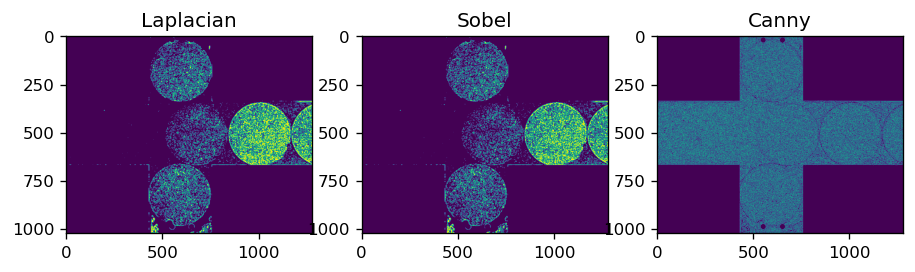

In [13]:
# Test some of the different edge detection methods
fig, ax = plt.subplots(1, 3, figsize=(9, 4))

horiSobelFilter = np.array([[1, 2, 1],
                            [0, 0, 0],
                            [-1, -2, -1]], dtype=np.float64)
vertiSobelFilter = np.array([[-1, 0, 1],
                             [-2, 0, 2],
                             [-1, 0, 1]], dtype=np.float64)

ax[0].imshow(laplacianEdgeDetection(image*maskArr))
ax[0].set_title('Laplacian')

ax[1].imshow(sobelEdgeDetection(image*maskArr))
ax[1].set_title('Sobel')

ax[2].imshow(cannyEdgeDetection(image*maskArr, threshold=.0001))
ax[2].set_title('Canny')

plt.show()

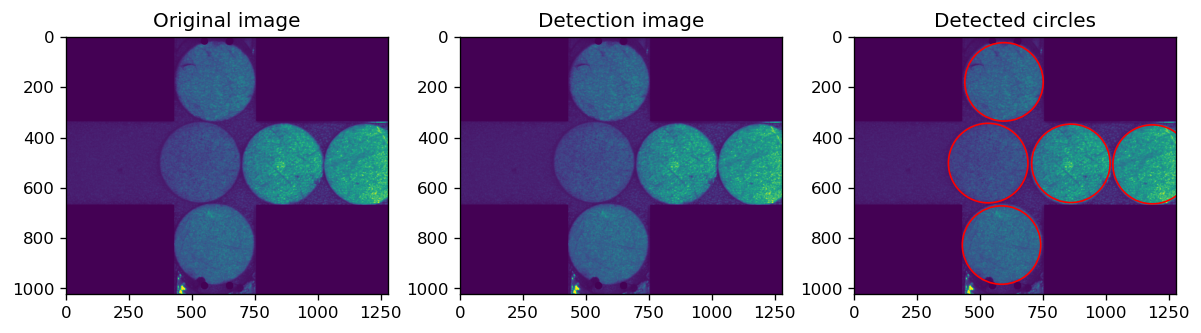

[[ 502.5  861.5]
 [ 827.5  585.5]
 [ 178.5  595.5]
 [ 501.5  532.5]
 [ 506.5 1185.5]] [155.9 155.9 155.9 158.1 157. ]


In [51]:
centers, radii = houghCircle((image[:,:,0]) * maskArr[:,:,0], 155, edgeDetection=None,
                             accumulatorThreshold=20, cannyEdgeThreshold=60,
                             blurKernel=None, draw=True, radiusTolerance=7)

print(centers, radii)

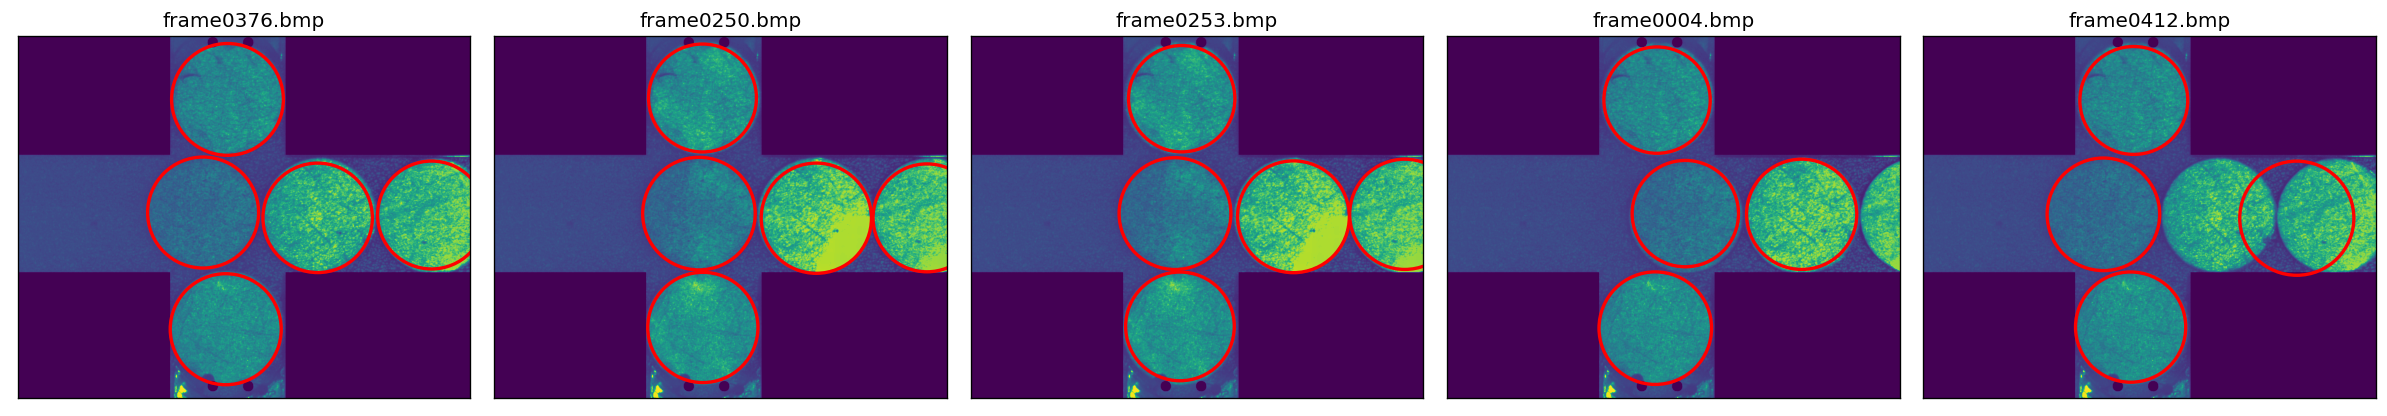

In [20]:
# Now let's test it on a whole bunch of images
testCases = 5
saturationLimit = .7

testImages = np.random.choice(os.listdir(dataFolder + '2022-02-02_Wide/'), size=testCases)

fig, ax = plt.subplots(1, testCases, figsize=(4*testCases, 4))

for i in range(testCases):
    image = checkImageType(dataFolder + f'2022-02-02_Wide/{testImages[i]}')

    image[image > np.max(image)*saturationLimit] = np.max(image)*saturationLimit
    
    centers, radii = houghCircle((image[:,:,0] + correction) * maskArr[:,:,0], 155, edgeDetection=None,
                             accumulatorThreshold=20, cannyEdgeThreshold=60,
                             blurKernel=None, radiusTolerance=7)
    
    ax[i].imshow((image[:,:,0] + correction) * maskArr[:,:,0])
    ax[i].set_title(testImages[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    for j in range(len(centers)):
        c = plt.Circle(centers[j][::-1], radii[j], color='red', fill=False, linewidth=2)
        ax[i].add_artist(c)
        
fig.tight_layout()
plt.savefig('tracking_test.png')
plt.show()

In [114]:
problematicImages = ['0263', '0084', '0019', '0266', '0161', '0294', '0178', '0246', '0237']

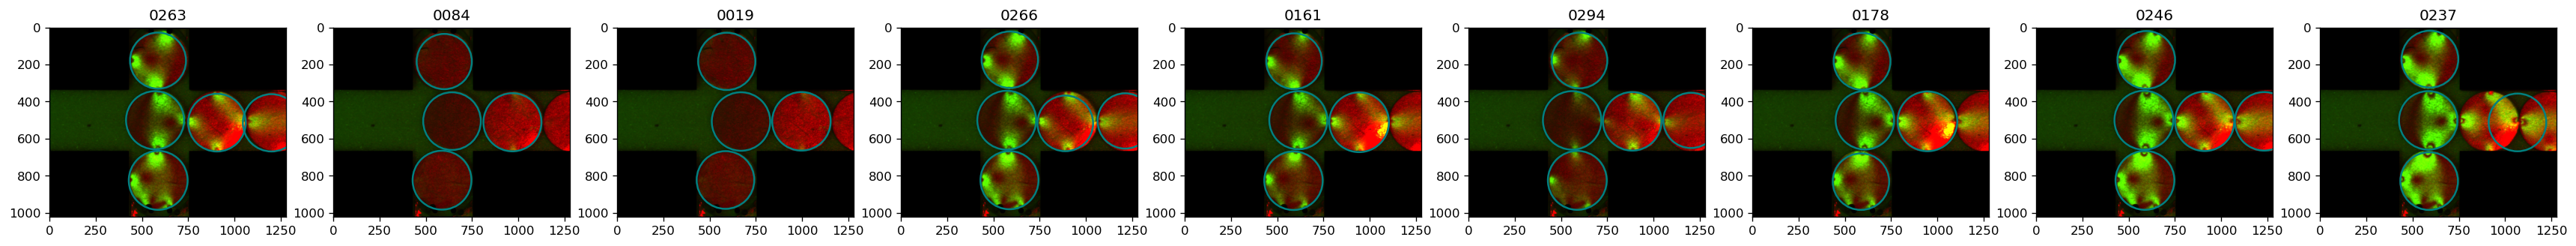

In [115]:
# Now let's test it on a whole bunch of images
testCases = 5

fig, ax = plt.subplots(1, len(problematicImages), figsize=(4*len(problematicImages), 4))

for i in range(len(problematicImages)):
    image = checkImageType(dataFolder + f'2022-02-02_Wide/frame{problematicImages[i]}.bmp')

    centers, radii = houghCircle((image[:,:,0] + correction) * maskArr[:,:,0], 155, edgeDetection=None,
                             accumulatorThreshold=20, cannyEdgeThreshold=60,
                             blurKernel=None, radiusTolerance=7)
    
    ax[i].imshow(image * maskArr)
    ax[i].set_title(problematicImages[i])
    for j in range(len(centers)):
        c = plt.Circle(centers[j][::-1], radii[j], color='teal', fill=False, linewidth=1.5)
        ax[i].add_artist(c)
        
plt.show()

In [22]:
convolutionArr = kernelFind(image[:,:,0]*maskArr[:,:,0], 1 - circularMask((240, 240), (120, 120), 120), debug=True, fftPadding=200)

TypeError: No loop matching the specified signature and casting was found for ufunc true_divide

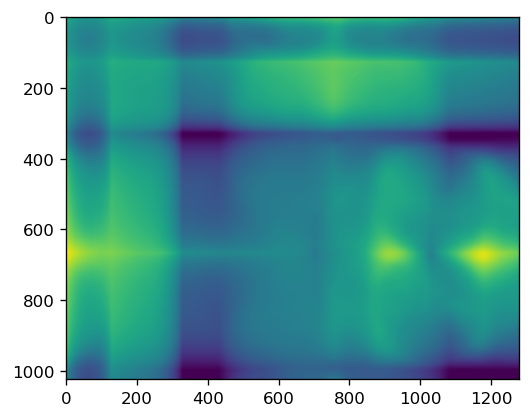

In [4]:
plt.imshow(np.abs(convolutionArr))

In [20]:
from scipy.ndimage.filters import uniform_filter1d, correlate1d

def lowpass(image, sigma=1, truncate=4):
    """Remove noise by convolving with a Gaussian.
    Convolve with a Gaussian to remove short-wavelength noise.
    The lowpass implementation relies on scipy.ndimage.filters.gaussian_filter,
    and it is the fastest way known to the authors of performing a bandpass in
    Python.
    Parameters
    ----------
    image : ndarray
    sigma : number or tuple, optional
        Size of the gaussian kernel with which the image is convolved.
        Provide a tuple for different sizes per dimension. Default 1.
    truncate : number, optional
        Determines the truncation size of the convolution kernel. Default 4.
    Returns
    -------
    result : array
        the processed image, as float
    See Also
    --------
    bandpass
    """
    sigma = validate_tuple(sigma, image.ndim)
    result = np.array(image, dtype=float)
    for axis, _sigma in enumerate(sigma):
        if _sigma > 0:
            correlate1d(result, gaussian_kernel(_sigma, truncate), axis,
                        output=result, mode='constant', cval=0.0)
    return result

def validate_tuple(value, ndim):
    if not hasattr(value, '__iter__'):
        return (value,) * ndim
    if len(value) == ndim:
        return tuple(value)
    raise ValueError("List length should have same length as image dimensions.")


def gaussian_kernel(sigma, truncate=4.0):
    "1D discretized gaussian"
    lw = int(truncate * sigma + 0.5)
    x = np.arange(-lw, lw+1)
    result = np.exp(x**2/(-2*sigma**2))
    return result / np.sum(result)

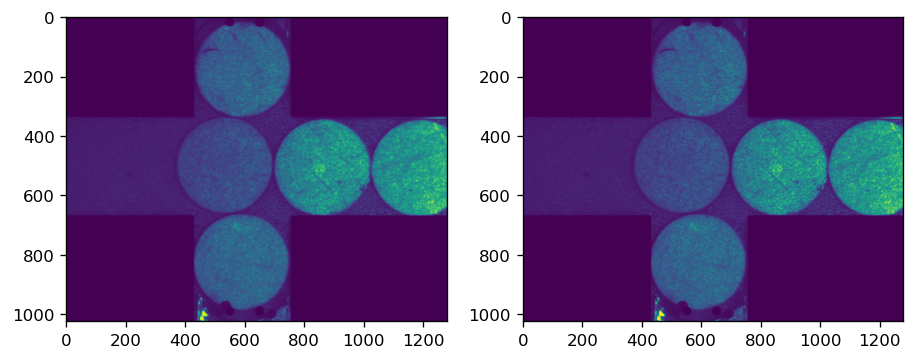

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(9,4))

ax[0].imshow(lowpass(image[:,:,0]*maskArr[:,:,0]))
ax[1].imshow(image[:,:,0]*maskArr[:,:,0])

plt.show()

In [16]:
img = Image.fromarray(image*maskArr)
img.save('test.png')

ker = Image.fromarray(circularMask((240, 240), (120, 120), 120)*255)
ker.save('ker.png')